## Installing uv

To start, you'll want to have uv installed:

https://docs.astral.sh/uv/getting-started/installation/


**Next, run this in the terminal, from the parent directory:**

    uv sync


Now you will have the kernel used to run this notebook

---

## Running the Required Servers

You need to run **three servers**, each in its own terminal:

- `central_server.py`
- `AS_server_SimAtomRes.py`
- `Ceos_server_twin.py`

### 1. Activate the Virtual Environment

`uv` should have created a `.venv` directory for you.

**On macOS / Linux:**

    source .venv/bin/activate

**On Windows (likely):**

    source .venv/Scripts/activate

You should now see the environment activated.

---

### 2. Start the Servers

**Terminal 1 — Central Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.protocols.central_server

**Terminal 2 — Atom Resolution Simulation Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.AS_server_SimAtomRes

**Terminal 3 — CEOS Twin Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.Ceos_server_twin

---

You're now ready to run this notebook! 🚀

In [1]:
import sys
import ast
sys.path.insert(0, '../')
from asyncroscopy.clients.notebook_client import NotebookClient
import matplotlib.pyplot as plt

import pyTEMlib
from pyTEMlib import probe_tools as pt

### Connections:

In [3]:
# Connect the Client to the central (async) server
tem = NotebookClient.connect(host='localhost',port=9000)

# Tell the central server address of all connected instruments
routing_table= {"AS": ("localhost", 9001),
                "Gatan": ("localhost", 9002),
                "Ceos": ("localhost", 9003),
                "Preacquired_AS": ("localhost", 9004)}
tem.send_command('Central',"set_routing_table", routing_table)

# ConnectionResetError: [Errno 54] Connection reset by peer 
# in terminal, type:
# lsof -i :9000

Connecting to central server localhost:9000...
Connected to central server.


'[Central] Routing table updated'

In [4]:
# connect to the AutoScript computer and initialize microscope
tem.send_command('AS',command='connect_AS',args={'host':'10.46.217.241','port':9095})

'[AS] Connected to microscope.'

In [10]:
tem.send_command(destination = 'Ceos', command = 'acquireTableau', args = {'tabType':"Fast", 'angle':18})


array([ 50,  48,  55,  58, 123,  34, 106, 115, 111, 110, 114, 112,  99,
        34,  58,  32,  34,  50,  46,  48,  34,  44,  32,  34, 101, 114,
       114, 111, 114,  34,  58,  32, 123,  34,  99, 111, 100, 101,  34,
        58,  32,  45,  51,  50,  48,  48,  48,  44,  32,  34, 109, 101,
       115, 115,  97, 103, 101,  34,  58,  32,  34,  83, 101, 114, 118,
       101, 114,  32, 101, 114, 114, 111, 114,  34,  44,  32,  34, 100,
        97, 116,  97,  34,  58,  32, 123,  34, 116, 121, 112, 101,  34,
        58,  32,  34,  60,  99, 108,  97, 115, 115,  32,  39,  69, 120,
        99, 101, 112, 116, 105, 111, 110,  39,  62,  34,  44,  32,  34,
       109, 101, 115, 115,  97, 103, 101,  34,  58,  32,  34,  77, 101,
        97, 115, 117, 114, 101, 100,  32, 112, 114, 111,  98, 101,  32,
       100, 105,  97, 109, 101, 116, 101, 114,  32, 111, 117, 116,  32,
       111, 102,  32, 114,  97, 110, 103, 101,  58,  32, 116,  97, 114,
       103, 101, 116,  61,  50,  48,  46,  48,  32, 112, 120,  4

### Help commands:

In [5]:
# Now that we're routed to all instruments,
# let's take an inventory of commands available on each instrument
cmds = tem.send_command('AS', 'discover_commands')
print(cmds)

["connect_AS", "connectionLost", "connectionMade", "dataReceived", "disconnect", "discover_commands", "get_help", "get_scanned_image", "get_stage", "get_status", "lengthLimitExceeded", "logPrefix", "makeConnection", "pauseProducing", "resumeProducing", "sendString", "stopProducing", "stringReceived"]


In [6]:
# These two are working, but should be much better.
tem.send_command('AS', command='get_help', args={'command_name':'connect_AS'})

'{"name": "connect_AS", "signature": "(args: dict)", "summary": "Connect to the microscope via AutoScript", "doc": "Connect to the microscope via AutoScript"}'

### Setting the aberrations from known values:

In [7]:
aberrations = pt.get_target_aberrations("Spectra300", 60000)
tem.send_command(destination = 'Ceos', command = 'uploadAberrations', args = aberrations)
pt.print_aberrations(aberrations)

In [8]:
# at any time, we can view the current aberrations
# this should be implemented in the real ceos server as well
ab = tem.send_command(destination = 'Ceos', command = 'getAberrations', args={})
ab = ast.literal_eval(ab)
pt.print_aberrations(ab)

### Get an image:

simulated with pystemsim inside the AS_server_SimAtomRes (working with the Ceos server)

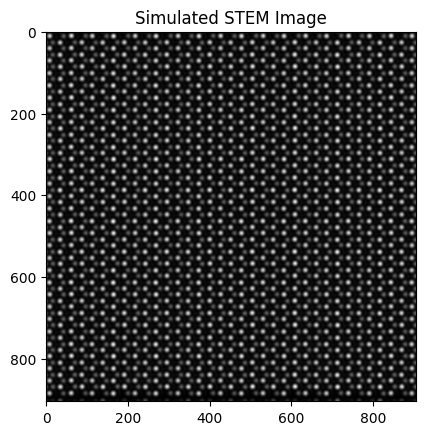

In [10]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':10e-6}

img = tem.send_command('AS','get_scanned_image', image_args)

plt.imshow(img, cmap="gray")
plt.title("Simulated STEM Image")
plt.show()


### How it's actually working:
![Structure Diagram](../DT_workflow.png)

### try changing an aberration

In [ ]:
tem.send_command(destination = 'Ceos', command = 'correctAberration', args = {"name": 'C10', "value": -6})

In [ ]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':10e-6}

img = tem.send_command('AS','get_scanned_image', image_args)

plt.imshow(img, cmap="gray")
plt.title("Simulated STEM Image")
plt.show()